In [2]:
import seaborn as sns
import jax
import ott
import diffrax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from entot.data.data import MixtureNormalSampler
from entot.models.model import OTFlowMatching
from entot.nets.nets import MLP_vector_field, Bridge_MLP_mean
from entot.plotting.plots import plot_1D_balanced

/home/icb/dominik.klein/miniconda3/envs/entot_env/lib/python3.11/site-packages/equinox/_ad.py:753: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/entot_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: I

In [3]:
source = MixtureNormalSampler(jax.random.PRNGKey(0), [0], 1,  0.5, batch_size=256)
target = MixtureNormalSampler(jax.random.PRNGKey(1), [-1.0,1.0], 1,  0.1, batch_size=256)

2023-08-01 10:28:52.580085: E external/xla/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.2.89, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2023-08-01 10:28:52.580976: W external/xla/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-08-01 10:28:52.580989: W external/xla/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at /usr/local/cuda/bin/ptxas
2023-08-01 10:28:52.594125: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:548] failed to load PTX text as a module: CUDA_ERROR_INVALID_IMAGE: device kernel image is invalid
2023-08-01 10:28:52.594142: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:553] error log buffer (63 bytes): error   : Binary format for key='0', ident='' is not recognize
2023-08-01 10:28:52.594172: W external/xla/xla/service/gpu/runtime/suppo

XlaRuntimeError: INTERNAL: Failed to execute XLA Runtime executable: run time error: custom call 'xla.gpu.func.launch' failed: Failed to load PTX text as a module: CUDA_ERROR_INVALID_IMAGE: device kernel image is invalid; current tracing scope: fusion; current profiling annotation: XlaModule:#hlo_module=jit__threefry_seed,program_id=0#.

In [ ]:
neural_net = MLP_vector_field(1, 128, 128, 128, n_frequencies=10)
bridge_net = Bridge_MLP_mean(1, 128, 128)
ot_solver = ott.solvers.linear.sinkhorn.Sinkhorn()
solver_latent_to_data = ott.solvers.linear.sinkhorn.Sinkhorn()

otfm = OTFlowMatching(neural_net, bridge_net=bridge_net, ot_solver=ot_solver, epsilon=1e-3, input_dim=1, output_dim=1, iterations=20_000, k_noise_per_x=10, solver_latent_to_data=solver_latent_to_data)

In [ ]:
otfm(source, target, 256, 256)

In [6]:
source.batch_size = 1024
source_batch = next(source)
res, _ , _= otfm.transport(source_batch, seed=0)

<Axes: ylabel='Density'>

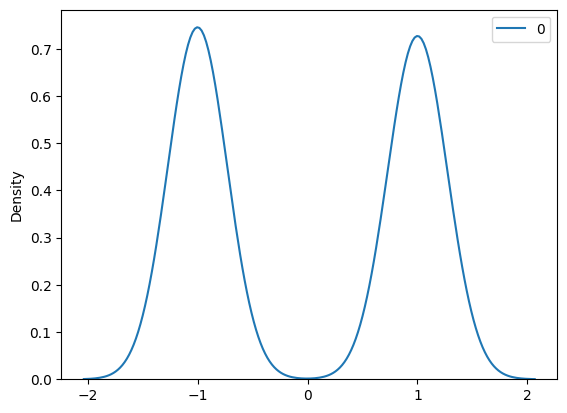

In [7]:
sns.kdeplot(res[0,...])

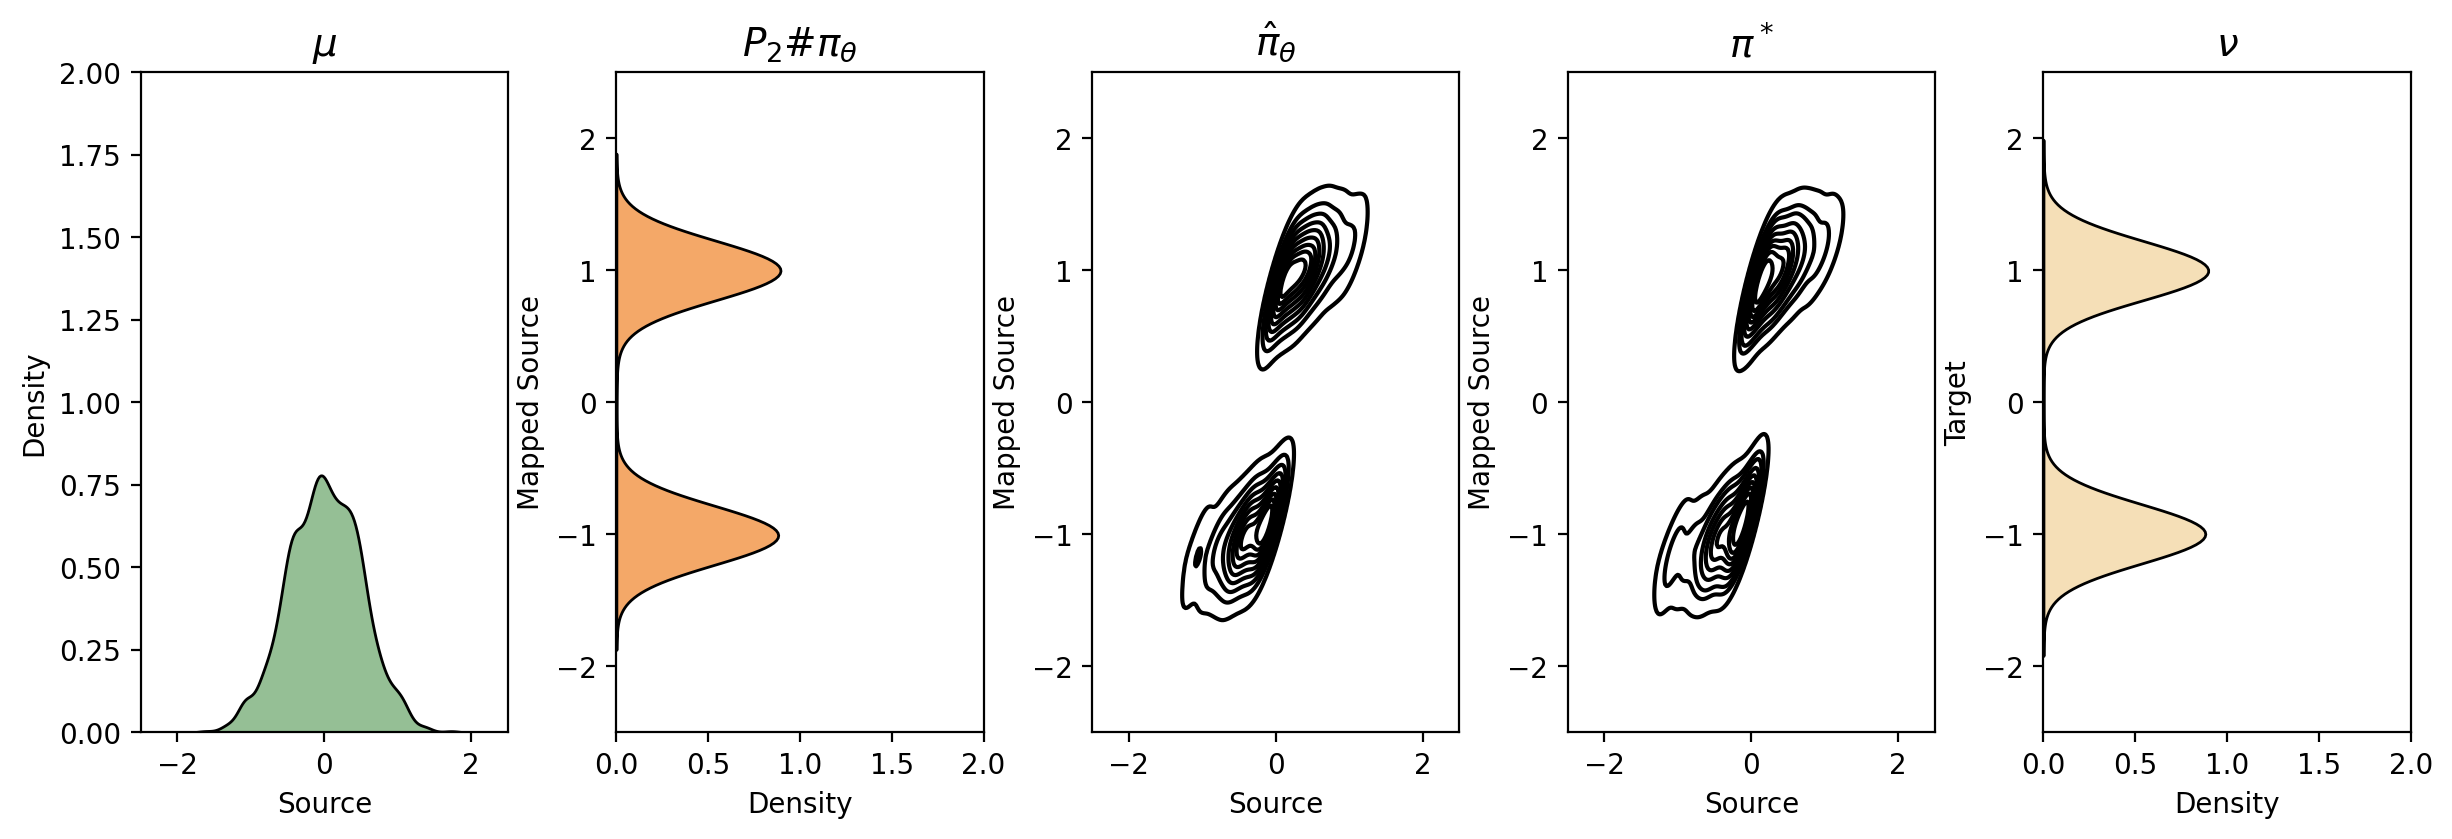

In [10]:
kwargs = {}
a = (-2.5, 2.5)
b = (0.0, 2.0)

kwargs["00_xlim"] = a
kwargs["01_xlim"] = b
kwargs["02_xlim"] = a
kwargs["10_xlim"] = a
kwargs["11_xlim"] = b
kwargs["12_xlim"] = b

kwargs["00_ylim"] = b
kwargs["01_ylim"] = a
kwargs["02_ylim"] = a
kwargs["10_ylim"] = a
kwargs["11_ylim"] = a
kwargs["12_ylim"] = a

kwargs["bw_adjust"] = 0.8

source.batch_size = 1024
source_batch = next(source)

target.batch_size = 1024
target_batch = next(target)

res, _, _ = otfm.transport(source_batch, seed=1, diffeqsolve_kwargs={"max_steps": 1_000_000})

_  = plot_1D_balanced(source_batch, target_batch, res[0,...], 1e-3, **kwargs)

## Plotting the vector fields

In [11]:
source_repeat = jnp.ones((1,)) * 0.0
source_repeat = jnp.repeat(source_repeat, 200)[:, None]

ts = np.linspace(0,1,20)
saveat=diffrax.SaveAt(ts=ts)

res, sol, _ = otfm.transport(source_repeat, seed=0, diffeqsolve_kwargs={"saveat": saveat})

tracks = sol.ys[...,0]

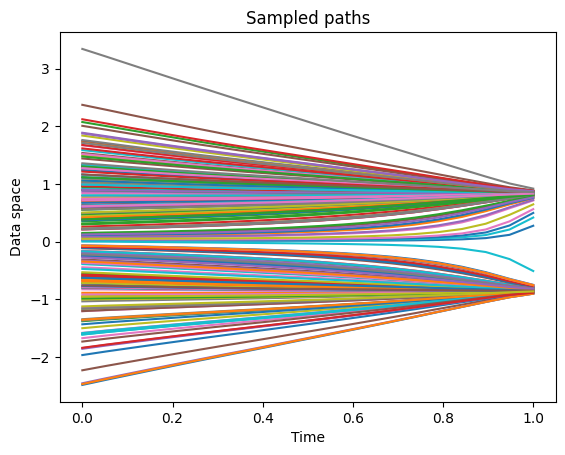

In [12]:
plt.plot(ts, tracks)
plt.xlabel("Time")
plt.ylabel("Data space")
plt.title("Sampled paths")
plt.show()

In [13]:
source_repeat = jnp.ones((1,)) * 0.0
source_repeat = jnp.repeat(source_repeat, 20)[:, None]

ts = np.linspace(0,1,20)
saveat=diffrax.SaveAt(ts=ts)

res, sol, _ = otfm.transport(source_repeat, seed=0, diffeqsolve_kwargs={"saveat": saveat})

tracks = sol.ys[...,0]

t_vec = ts[1:] - ts[:-1]
t_vector = np.tile(t_vec[:, None], (1, tracks.shape[-1]))
y_vector = tracks[1:, ...] - tracks[:-1,...]
t_augmented = np.tile(ts[:, None], (1, tracks.shape[-1]))[:-1, ...]

Text(0, 0.5, 'Target space')

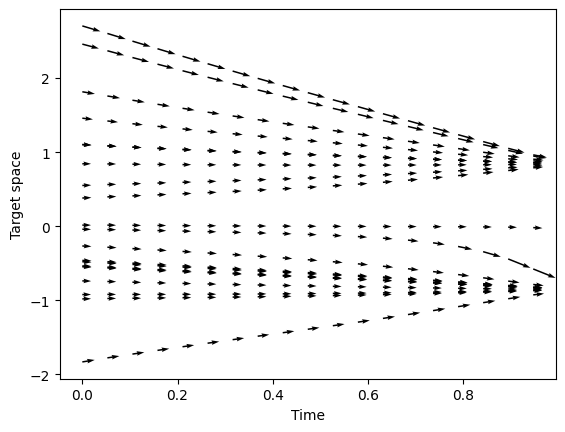

In [14]:
plt.quiver(t_augmented, tracks[:-1], t_vector, y_vector, angles="xy", scale=3)#,  headwidth=5, headlength=2, headaxislength=5)
plt.xlabel("Time")
plt.ylabel("Target space")